# **"Гиперболические ИПСоиды"'s solution to [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6) completed as a selection task to INT20TH Hackathon**

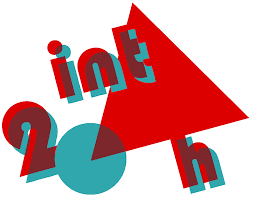

### Setting up global variables and libraries

In [1]:
import os
import sys
import glob
import json
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = os.path.abspath("data")
ROOT_PATH = os.path.abspath("")

We are choosing a 512x512 image size and ignoring class attributes, since they are difficult to predict and without them, the metrics are better. Besides, according to the host, 80% of images have no attributes at all. So we'll predict only classes

In [4]:
IMG_SIZE = 512
CLASS_NUM = 46

## Choosing model and downloading it's weights

We've looked through all the State of the Art solutions for Instance Segmentation and for this task we've chosen *Mask R-CNN* because:
* it's still considered as one of the STA solutions, despite the fact that it was published almost 2 years ago
* it's relatively light-weighted in comparison to other models
* we were able to train it on a custom data using kaggle kernels in quite a restricted time frame (other models, like *Hybrid Task Cascade with ResNeXt-101-64x4d-FPN*, would have taken an enormous time to train on kaggle

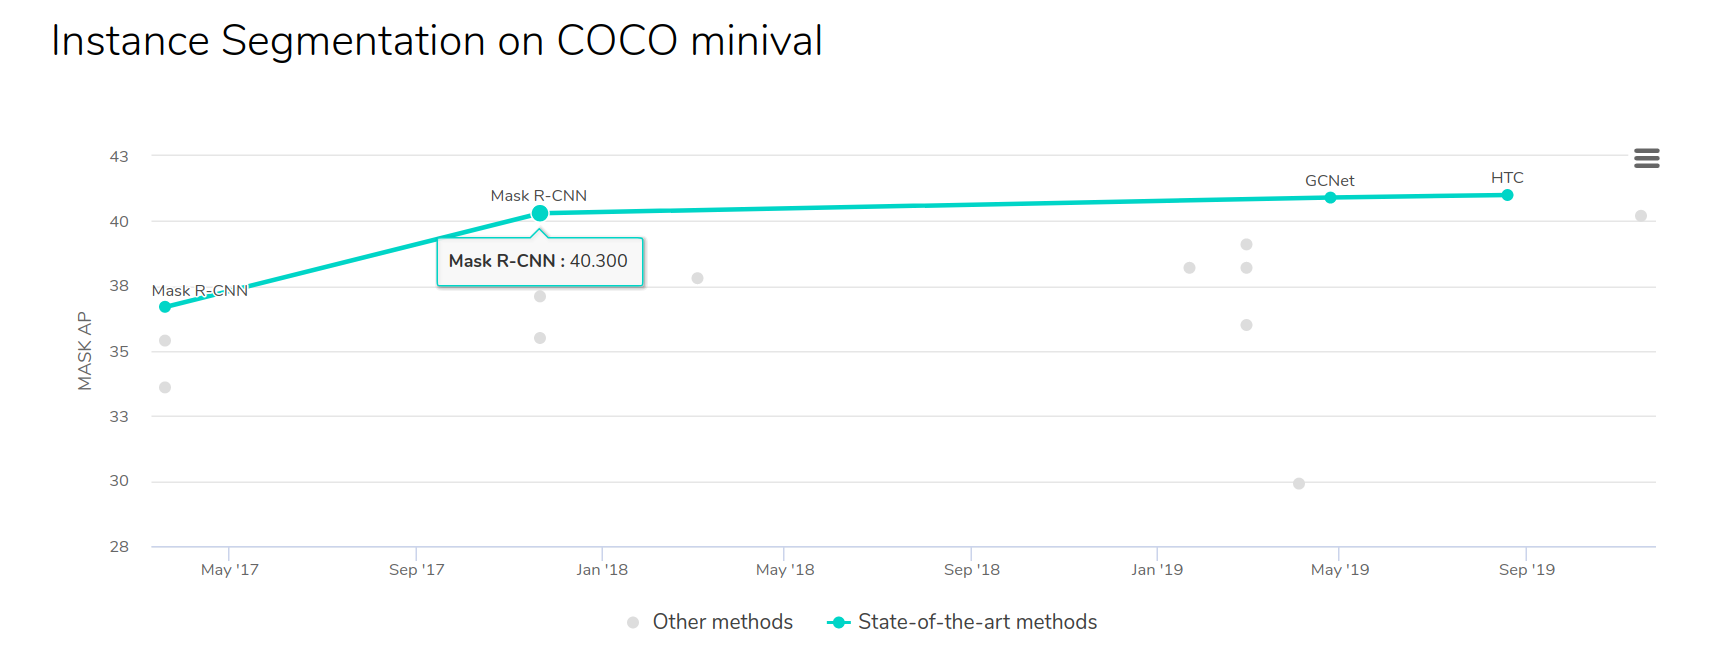

In [5]:
#clonning the model and it's pretrained on COCO dataset weights
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [6]:
sys.path.append(str(ROOT_PATH + '/Mask_RCNN'))
initial_weights_path = ROOT_PATH + "/weights/mask_rcnn_coco.h5"

In [7]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn.config import Config

Using TensorFlow backend.


## Creating configuration files

In [8]:
class TrainingConfig(Config):
    """Configuration used to train the model on Kaggle kernels"""
    NAME = "fashion"
    NUM_CLASSES = CLASS_NUM + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = TrainingConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class TestingConfig(TrainingConfig):
    """Configuration used to test the model locally, using the pretrained weights"""
    IMAGES_PER_GPU = 1

testing_config = TestingConfig()

## Creating Datasets for the model

In [10]:
with open(DATA_PATH + "/label_descriptions.json") as file:
    label_descriptions = json.load(file)

label_names = [x['name'] for x in label_descriptions['categories']]

In [11]:
segment_df = pd.read_csv(DATA_PATH + "/train.csv")

In [12]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]  # 10(classId)_1_2_3(attributeIds) => 10
segment_df.sample(10)

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
288360,df3e5777fc8822896e05e2bdf9e605c5.jpg,148525 1 150516 5 152508 8 154499 12 156491 15...,1994,1111,31,31
37361,1cd6493530f272379a9da6be28b8f431.jpg,1427980 8 1429573 23 1431166 38 1432758 54 143...,1600,1600,32,32
181757,8ce833e81df2e137513acfe00ea833d6.jpg,603428 2 604925 6 606421 11 607918 14 609414 1...,1500,954,29,29
323484,fa26e7b6821aab74f4de49cad1e5b186.jpg,60071 4 61547 13 63024 21 64500 30 65976 38 67...,1478,1000,31,31
26569,14a91ecd761d8aaf3e34231e73b1f3b4.jpg,10615216 4 10620128 11 10625040 16 10629952 17...,4912,3264,15,15
287517,de9c6080c23c643c3c74f0f27e36e18e.jpg,425134 2 426331 5 427527 8 428724 11 429920 14...,1200,800,33,33
146950,7195a80781724bbacd54999125fe6d26.jpg,2930870 7 2935431 20 2939992 33 2944554 45 294...,4569,3046,35,35
322541,f97e1b9f99c62bd332f941ffbb0a378d.jpg,124575 3 125325 8 126075 13 126825 17 127574 2...,753,500,32,32
236824,b76e48405f4e1544fc5d67d23f5933aa.jpg,1959939 6 1961883 13 1963832 15 1965782 27 196...,1950,2600,13,13
246657,bf25d82ed2f7e2331c74d6bd798c9c7d.jpg,1838530 24 1841586 72 1844663 99 1847763 102 1...,3103,1505,31,31


As we see, one image may have multiple attributes. So we grup them up

In [13]:
segment_df = segment_df.set_index("ImageId")
train_idxs, test_idxs = train_test_split(np.unique(segment_df.index.values), test_size=0.2, random_state=42, shuffle=True)

train_df_raw = segment_df.loc[train_idxs]
test_df_raw = segment_df.loc[test_idxs]

In [14]:
train_image_df = train_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
train_size_df = train_df_raw.groupby('ImageId')['Height', 'Width'].mean()
train_image_df = train_image_df.join(train_size_df, on='ImageId')

print("Total train images: ", len(train_image_df))
train_image_df.head()

Total train images:  36156


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
00048c3a2fb9c29340473c4cfc06424a.jpg,[239016 3 239989 6 240963 7 241938 8 242913 9 ...,"[13, 1, 33, 8, 35, 24, 23, 23]",975,650
0006ea84499fd9a06fefbdf47a5eb4c0.jpg,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,"[1, 33, 8, 23, 23]",1000,667


In [15]:
test_image_df = test_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
test_size_df = test_df_raw.groupby('ImageId')['Height', 'Width'].mean()
test_image_df = test_image_df.join(test_size_df, on='ImageId')

print("Total test images: ", len(test_image_df))
test_image_df.head()

Total test images:  9039


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500
000775b6b5e27b011dc8bba2d7b85211.jpg,[426259 9 427858 12 429457 14 431056 17 432655...,"[33, 1, 19, 6, 31, 31]",1600,1067
000cd2e13d1bdd28f480304d7bb9e1ca.jpg,[1522034 13 1525024 39 1528014 64 1531004 90 1...,"[1, 31, 28, 7, 35, 23, 23, 37, 37]",3000,2000
0017af9f7fa8ce9e7558bb924cec324e.jpg,[169688 9 171477 25 173265 43 175053 60 176841...,"[6, 1, 31, 31, 33]",1797,607


In [16]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Redefining *utils.Dataset* for our use case

In [17]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_PATH + '/train/'+ row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMG_SIZE, IMG_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Image and their masks examples 

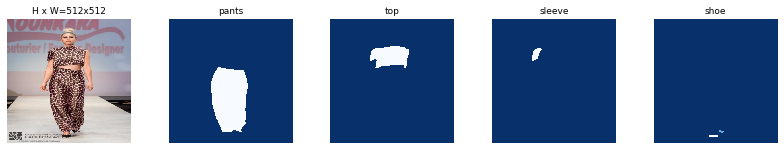

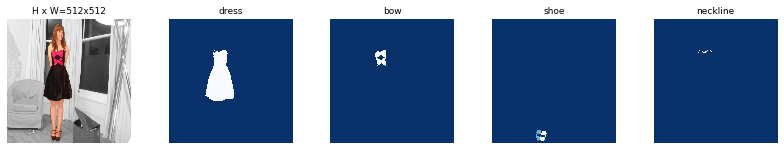

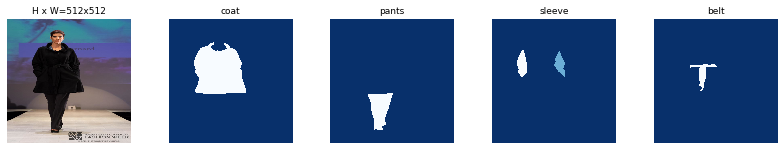

In [18]:
dataset = FashionDataset(train_image_df)
dataset.prepare()

test_dataset = FashionDataset(test_image_df)
test_dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Partitioning data into train and validation sets. Since we can't validate our prediction using Kaggle, we'll calculate final validation score using 20% of the train data

In [19]:
# since we want to test our model on the data it never saw, we'll split it
train_df, valid_df = train_test_split(train_image_df, test_size=0.2, random_state=42, shuffle=True)

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's check the class distribution of the splitted datasets

Total train images:  28924
Total train segments:  212287


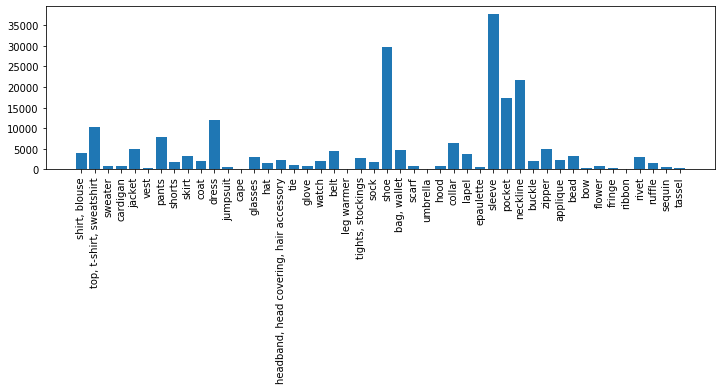

Total validation images:  7232
Total validation segments:  52662


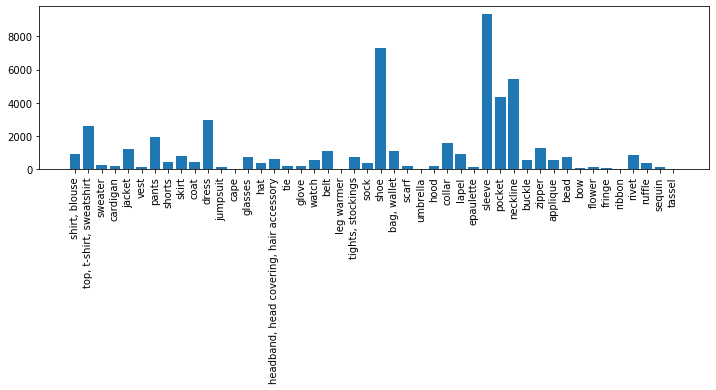

In [20]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Training

Taking into account similarities between COCO and iMaterialist datasets, we've decided to use Transfer Learning and to use pre-trained weights of the Mask R-CNN model. We've trained only the top part of our model for 10 epochs. Because each epoch took more than 1 hour to finish, we did that in a few kernel sessions, gradually decreasing learning rate as we came closer to loss minimum. We used the following learning rate scheduler:
```
lr = 1e-2
if epochs > 6: 
    lr = lr ∗ 0.1 
if epochs > 8: 
    lr = lr ∗ 0.1 
if epochs == 10: 
    lr = lr ∗ 0.1```

In [21]:
weights_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0007.h5"

To make our model more robust and diversify our dataset we've used image augmentations:

In [22]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flip
    iaa.Multiply((0.3, 1.2), per_channel=0.5), # change brightness of images (30-120% of original value)
    iaa.ContrastNormalization((0.3, 1.2), per_channel=0.5),
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.arithmetic.JpegCompression((80, 90))
])

In [23]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_PATH)

#loading weights from previous epoch
model.load_weights(weights_path, by_name=True)

W0126 20:17:08.328814 139726504748864 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0126 20:17:08.346065 139726504748864 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0126 20:17:08.362341 139726504748864 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0126 20:17:08.382493 139726504748864 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.

In [26]:
model.train(train_dataset, valid_dataset,
        learning_rate=0.001,
        epochs=3,
        layers='all',
        augmentation=augmentation)

Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_log

## Testing

In [27]:
model_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0010.h5"

model = modellib.MaskRCNN(mode='inference', 
                          config=testing_config,
                          model_dir=ROOT_PATH)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0126 20:31:21.099956 139771212646208 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0126 20:31:21.116806 139771212646208 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0126 20:31:21.119361 139771212646208 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0126 20:31:21.140133 139771212646208 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.

Loading weights from  /home/vzalevskyi/git/int20th_selection/weights/mask_rcnn_fashion_0010.h5


#### Some helper functions to get EncodedPixels from masks

In [28]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle


# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois



# number of images to predict from the test set
#num_to_predict = 1000

# or to select all (~9k)
num_to_predict= len(test_idxs)

In [30]:
%%time
# predicting images
sub_list = []
missing_count = 0
for i, row in enumerate(test_image_df.index.values[:num_to_predict]):
    
    image = resize_image(DATA_PATH + '/train/'+ row)
    
    result = model.detect([image])[0]
    
    if result['masks'].size > 0:
        
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row, ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row, '1 1', 23])
        missing_count += 1

CPU times: user 32min 34s, sys: 40.1 s, total: 33min 14s
Wall time: 6min 23s


In [39]:
prediction_df = pd.DataFrame(sub_list, columns=['ImageId', "EncodedPixels", 'CategoryId'])
print("Total image results: ", prediction_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
prediction_df.head()

Total image results:  9039
Missing Images:  36


,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,150966 16 151439 60 151950 62 152461 63 152973...,31
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,58810 6 59309 29 59809 43 60144 41 60307 59 60...,31
2,0000fe7c9191fba733c8a69cfaf962b7.jpg,135793 1 136305 1,33
3,0000fe7c9191fba733c8a69cfaf962b7.jpg,112239 1 112751 1 113263 1 113775 1 114287 1 1...,33
4,0000fe7c9191fba733c8a69cfaf962b7.jpg,179857 5 180361 22 180869 32 181374 45 181881 ...,31


In [42]:
prediction_df.to_csv(f"predictions_{num_to_predict}_010.csv", index=False)

In [43]:
prediction_df = pd.read_csv(f"predictions_{num_to_predict}_010.csv", index_col="ImageId")

In [44]:
prediction_df = prediction_df.rename({"ClassId":"CategoryId"}, axis=1).drop(columns=["Unnamed: 0"])
prediction_df.head()

,EncodedPixels,CategoryId
ImageId,,
708593d06ca574ed8f82e58de1546ed0.jpg,163821 4 164330 8 164840 10 165333 1 165347 15...,23
708593d06ca574ed8f82e58de1546ed0.jpg,163310 1 163819 2 163825 1 164329 1 164838 2 1...,23
708593d06ca574ed8f82e58de1546ed0.jpg,210692 3 211203 4 211715 4 212226 5 212666 14 ...,31
051304baf10af948afc409fed4e15be3.jpg,53945 6 54452 16 54960 23 55469 28 55978 33 56...,31
051304baf10af948afc409fed4e15be3.jpg,99780 6 99788 5 100291 16 100803 16 101317 14 ...,23


In [45]:
print("Masks detected:", len(prediction_df)) 
print("Images predicted:", len(np.unique(prediction_df.index.values)))

Masks detected: 53041
Images predicted: 9039


Let's visualise results!

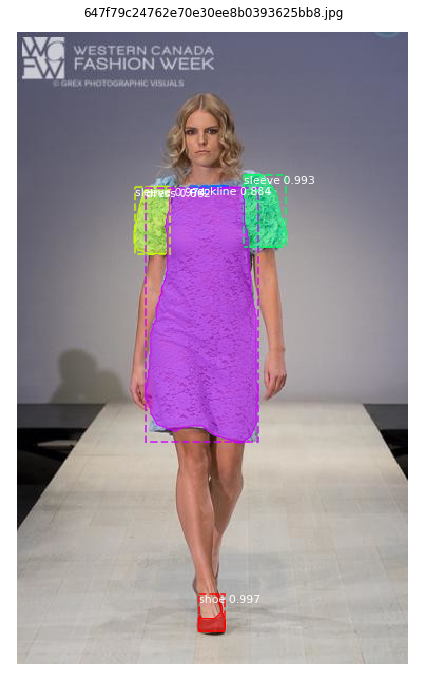

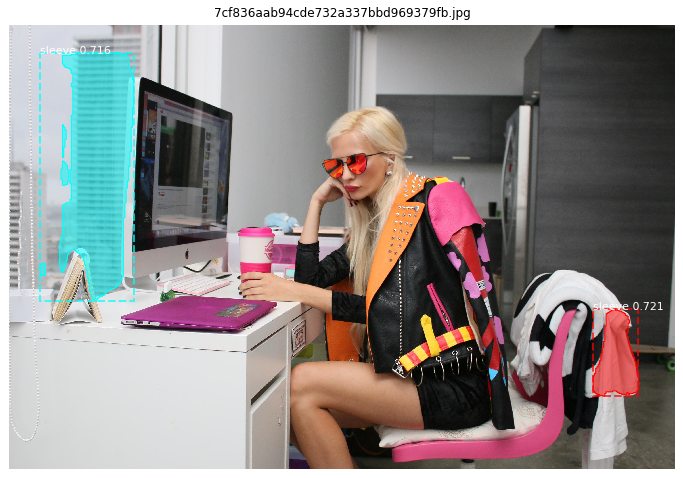

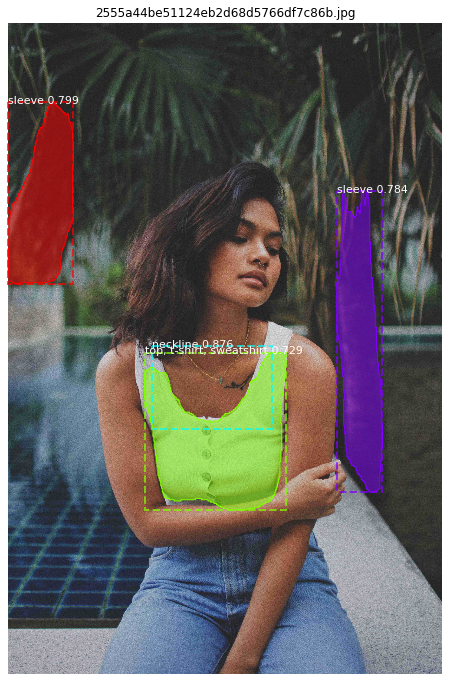

In [46]:
for i in range(3):
    image_id = prediction_df.sample().index.values[0]
    image_path = str(DATA_PATH + '/train/'+ image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMG_SIZE
        x_scale = img.shape[1]/IMG_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        print(image_id)
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

## Evaluating the model

In [47]:
# calculating ground_truth encoded pixels relativly to 512x512 size
gt_list = []

for idx in range(num_to_predict):
    image, image_meta, gt_class_id, gt_roi, gt_mask = modellib.load_image_gt(test_dataset, 
                                                                              TestingConfig, 
                                                                              idx)
    masks, _ = refine_masks(gt_mask, gt_roi)
    for m in range(masks.shape[-1]):

        mask = masks[:, :, m].ravel(order='F')
        rle = to_rle(mask)
        label = gt_class_id[m] - 1
        gt_list.append([test_idxs[idx], ' '.join(list(map(str, rle))), label])

In [48]:
gt_df = pd.DataFrame(gt_list)
gt_df = gt_df.rename({0:"ImageId", 1:"EncodedPixels", 2:"CategoryId"}, axis=1).set_index("ImageId")

#### Helper functions to compute competition's metric

It's evaluated on the mean average precision at different intersection over union (IoU) thresholds. Similar to the 2018 science bowl competition, the IoU of a proposed set of object pixels and a set of true object pixels is calculated as:

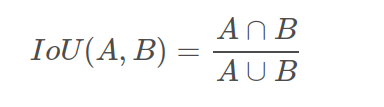

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

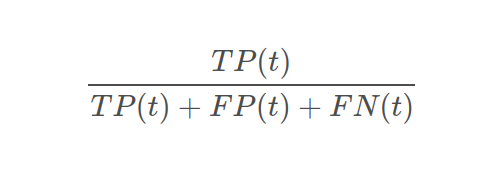

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single ClassId and a single image is then calculated as the mean of the above precision values at each IoU threshold:

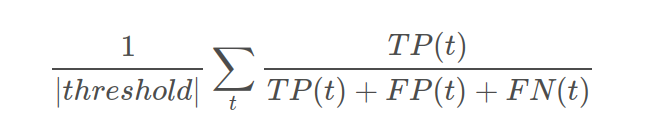

In [49]:
def calc_IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

def calc_IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_to_mask(data['EncodedPixels_gt'].split(), (int(data['Height']), int(data['Width'])))
    mask_pred = rle_to_mask(data['EncodedPixels_pred'].split(), (int(data['Height']), int(data['Width'])))
    return calc_IoU(mask_gt, mask_pred)

def evaluation(gt_df, pred_df):
    eval_df = pd.merge(gt_df, pred_df, how='outer', on=['ImageId', 'CategoryId'], suffixes=['_gt', '_pred'])
    #return eval_df
    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    
    IoU = eval_df[idx_].apply(calc_IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_gt'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        maybe_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp_IoU = fp + maybe_fp

        # Calculate evaluation score
        score = tp / (tp + fp_IoU + fn)
        scores.append(score)
    mean_score = sum(scores) / len(threshold_IoU)
    print(f"Mean precision score: {mean_score}")

In [52]:
# check that there is equal amount of images in gt_df and predicted_df
assert len(np.unique(prediction_df.index.values)) == len(np.unique(gt_df.index.values))

In [53]:
gt_df["CategoryId"] = gt_df["CategoryId"].astype("int64")

gt_df["Height"] = 512
gt_df["Width"] = 512

prediction_df = prediction_df.reset_index()
gt_df = gt_df.reset_index()

In [54]:
prediction_df.sample(10)

,ImageId,EncodedPixels,CategoryId
39940,8a3fd910db3cb079f3899166a9fa4ca2.jpg,95191 1 96214 1 96724 2 97234 4 97744 6 98255 ...,23
2197,5efb6b62098a7a075770a886d096544e.jpg,49609 9 50075 57 50523 86 50625 10 51011 109 5...,31
21427,97a44b970a4f47d30d6190ad0f8d0bea.jpg,133607 4 134116 8 134626 10 135137 11 135649 1...,23
26915,3c0e112995f3cb4511abd07ab1b547e5.jpg,194334 3 194846 3 195355 5 195864 8 196375 9 1...,23
37634,d92fe876cb3908ca8275d931b2aca37b.jpg,148787 5 149297 11 149809 21 150320 25 150832 ...,6
29239,341b86e6d7b956bcdd708239d7e8d137.jpg,106207 4 106718 10 107228 14 107736 19 108244 ...,31
2213,5efb6b62098a7a075770a886d096544e.jpg,49609 9 50075 57 50523 86 50625 10 51011 109 5...,31
24917,840984be401166c9a1862992507d5d4a.jpg,111067 1 111579 1 112091 1 112603 1 113115 1 1...,23
9655,6b6837c73fca0a115dd61271a3e3fdf9.jpg,187527 7 188038 10 188548 12 189058 14 189567 ...,31
28185,37374252c4a9a1ab4f0609eccd1277b7.jpg,NaN,33


In [55]:
gt_df.sample(10)

,ImageId,EncodedPixels,CategoryId,Height,Width
6168,5e1aa1a303b5d692011b756ed4a8d393.jpg,111441 1 111951 3 112462 4 112972 6 113483 7 1...,19,512,512
3233,134813a73832b05533ba02e5d30e3cfd.jpg,164668 3 165179 9 165689 15 166198 31 166708 3...,31,512,512
6188,b264dd3443577840e2aafd1e02550d25.jpg,157396 2 157906 5 158417 6 158919 8 158928 7 1...,31,512,512
6507,0bfa98535a2fa864cb6e9a2315547957.jpg,134360 4 134872 10 135384 17 135896 26 136407 ...,1,512,512
39,3263a575ffe8b2fd66a15104e9a6f308.jpg,156904 10 157411 24 157915 35 158426 38 158936...,31,512,512
4844,6b12f30dbca76f21c4b365e3b5d9fc56.jpg,36649 1 37161 1 37673 1 38184 2 38696 2 39208 ...,31,512,512
7047,e66bcfa07c2b8c25c59c969286f86d2e.jpg,123041 2 123048 14 123553 24 124065 27 124578 ...,28,512,512
170,22d8da04eb62e763bc608763b78770b5.jpg,103015 1 103526 3 104038 3 104550 3 105061 4 1...,14,512,512
990,da98c9a1095f87cb3e1b5de6c665e74c.jpg,122309 4 122821 6 123334 7 123847 7 124359 7 1...,23,512,512
1289,0f860d5dce34f6427717bb3879bab5b1.jpg,119784 1 120293 10 120802 13 121313 15 121825 ...,23,512,512


In [58]:
%%time
evaluation(gt_df, prediction_df)

Mean precision score: 0.008172632861366574
CPU times: user 1min 13s, sys: 11.7 ms, total: 1min 13s
Wall time: 1min 13s


## So finally, as we can see, we've achives a mean average precision score of about 0.0082 which is not great not terrible :)